In [60]:
import numpy as np
import matplotlib.pyplot as plt
from IPython import display as IPyDisplay
import time
import seaborn as sns; sns.set(); sns.set(style="whitegrid", color_codes=True)

# Read Data

In [61]:
import torch

from helpers.data_generator import generate_data, normalize


epochs = 100
batch_size = 100

def accuracy(predicted_logits, reference, argmax=True):
    """Compute the ratio of correctly predicted labels"""
    if argmax:
        labels = torch.argmax(predicted_logits, 1)
    else:
        labels = predicted_logits
    correct_predictions = labels.int().eq(reference.int())
    return correct_predictions.sum().float() / correct_predictions.nelement()

# autograd globally off
torch.set_grad_enabled(False)

train_data, train_label = generate_data()
test_data, test_label = generate_data()

mean, std = train_data.mean(), train_data.std()
print("Mean= ", mean, "STD= ",std)

train_data, test_data = normalize(train_data, test_data)
print("--- Dataset ---")
print("Train X: ", train_data.size(), " | Train y: ", train_label.size())
print(" Test X: ",  test_data.size(), " |  Test y: ", test_label.size())

Mean=  tensor(0.4911) STD=  tensor(0.2887)
--- Dataset ---
Train X:  torch.Size([1000, 2])  | Train y:  torch.Size([1000])
 Test X:  torch.Size([1000, 2])  |  Test y:  torch.Size([1000])


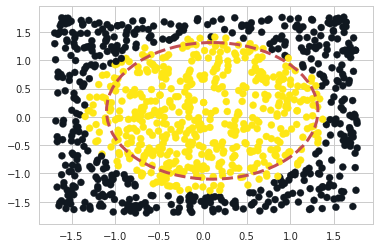

In [62]:
circle1 = plt.Circle(((0.5-mean.item())/np.power(std,2), (0.5-mean.item())/np.power(std,2)), ((1/np.sqrt(2*np.pi))-mean)/np.power(std,2.07), color='r', fill=False, lw=3, ls="--")

fig, ax = plt.subplots()
ax.scatter(train_data[:,0].numpy(), train_data[:,1].numpy(), c=["#101820FF" if x==0 else "#FEE715FF" for x in np.squeeze(train_label.numpy())])
ax.add_artist(circle1)

---

# Our DL Framework Performance

In [4]:
from Sequential import Sequential
from activations.ReLu import Relu
from activations.Tanh import Tanh
from activations.Mish import Mish
from layers.Linear import Linear
from losses.mse import MSE
from optimizers.SGD import SGD
from weight_initialization.xavier_uniform import xavier_uniform

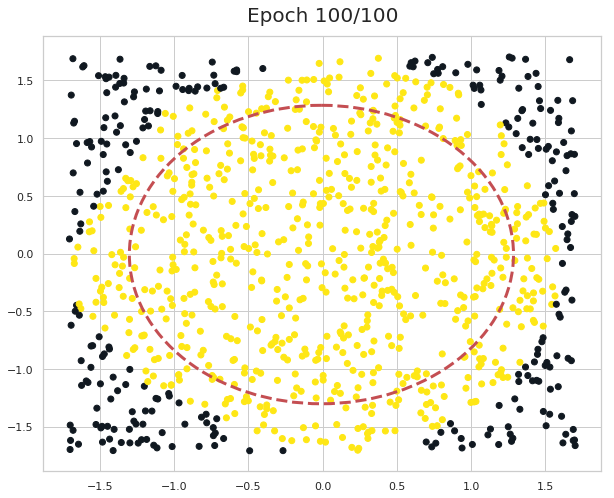

In [5]:
layers =[]
# input layer (2 input units)
linear1 = Linear(2, 25, bias= True, weight_init=xavier_uniform)

# 3 hidden layers (each 25 units)
linear2 = Linear(25, 25, bias= True, weight_init=xavier_uniform)
linear3 = Linear(25, 25, bias= True, weight_init=xavier_uniform)
linear4 = Linear(25, 25, bias= True, weight_init=xavier_uniform)

# output layer (2 output units)
linear5 = Linear(25, 2, bias= True, weight_init=xavier_uniform)


layers.append(linear1)
layers.append(Relu())
layers.append(linear2)
layers.append(Relu())
layers.append(linear3)
layers.append(Relu())
layers.append(linear4)
layers.append(Tanh())
layers.append(linear5)

model = Sequential(layers)

criterion = MSE()
optimizer = SGD(model, lr = 0.1)


train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []
train_errors, test_errors = [], []

ret_val = ""
verbose = 0 


for epoch in range(1, epochs+1):
    ret_val += "Epoch: " + str(epoch) + "\n"
    
    # TRAINING
    for batch_idx in range(0, train_data.size(0), batch_size):
        # axis 0, start from batch_idx until batch_idx+batch_size
        output = model.forward(train_data.narrow(0, batch_idx, batch_size))

        # Calculate loss
        loss = criterion.forward(output, train_label.narrow(0, batch_idx, batch_size))
        train_losses.append(loss)
        ret_val += "Loss: "+str(loss)+"\n"

        # put to zero weights and bias
        optimizer.zero_grad()

        ## Backpropagation
        # Calculate grad of loss
        loss_grad = criterion.backward()

        # Grad of the model
        model.backward(loss_grad)

        # Update parameters
        optimizer.step()
        
    train_prediction = model.forward(train_data)
    acc = accuracy(train_prediction, train_label)
    train_accuracies.append(acc)
    train_errors.append(1-acc)
    ret_val += "Train Accuracy: {:.2e}".format(acc.item())

    # EVALUATION
    for batch_idx in range(0, test_data.size(0), batch_size):
        # axis 0, start from batch_idx until batch_idx+batch_size
        output = model.forward(test_data.narrow(0, batch_idx, batch_size))

        # Calculate loss
        loss = criterion.forward(output, test_label.narrow(0, batch_idx, batch_size))
        test_losses.append(loss)
        ret_val += "Test Loss: {:.2e}".format(loss.item())
    
    test_prediction = model.forward(test_data)
    acc = accuracy(test_prediction, test_label)
    test_accuracies.append(acc)    
    test_errors.append(1-acc)
    ret_val += "Test Accuracy: {:.2e}".format(acc.item())
    
    
    pred = torch.argmax(test_prediction, 1)  
    fig, ax = plt.subplots(figsize=(10,8))
    ax.scatter(test_data[:,0].numpy(), test_data[:,1].numpy(), c=["#101820FF" if x==0 else "#FEE715FF" for x in np.squeeze(pred.numpy())])
    circle1 = plt.Circle(((0.5-mean.item())/np.power(std,2), (0.5-mean.item())/np.power(std,2)), ((1/np.sqrt(2*np.pi))-mean)/np.power(std,2.07), color='r', fill=False, lw=3, ls="--")
    ax.add_artist(circle1)
    ax.set_title(f"Epoch {epoch}/{epochs}", fontdict={"fontsize":20, "fontweight":1}, pad=15);
    IPyDisplay.clear_output(wait=True)
    IPyDisplay.display(plt.gcf())
    plt.close();
    time.sleep(0.1)

if verbose: print(ret_val)
    

# PyTorch Framework

In [7]:
from torch import nn

In [8]:
train_data.shape

torch.Size([1000, 2])

In [14]:
def init_weights(m):
    print(m)
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform(m.weight)
        #m.bias.data.fill_(0.01)

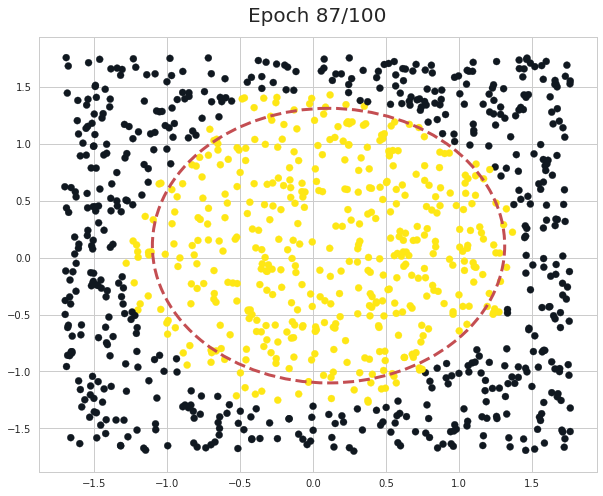

In [ ]:
# autograd globally off
torch.set_grad_enabled(True)

layers =[]
# input layer (2 input units)
linear1 = nn.Linear(2, 25, bias=True)

# 3 hidden layers (each 25 units)
linear2 = nn.Linear(25, 25, bias=True)
linear3 = nn.Linear(25, 25, bias=True)
linear4 = nn.Linear(25, 25, bias=True)

# output layer (2 output units)
linear5 = nn.Linear(25, 2, bias=True)


layers.append(linear1)
layers.append(nn.ReLU())
layers.append(linear2)
layers.append(nn.ReLU())
layers.append(linear3)
layers.append(nn.ReLU())
layers.append(linear4)
layers.append(nn.Tanh())
layers.append(linear5)

model = nn.Sequential(*layers)
model.apply(init_weights)

criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)


train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []
train_errors, test_errors = [], []

ret_val = ""
verbose = 0 


for epoch in range(1, epochs+1):
    ret_val += "Epoch: " + str(epoch) + "\n"
    
    # Enable training mode (automatic differentiation + batch norm)
    model.train()
    
    # TRAINING
    for batch_idx in range(0, train_data.size(0), batch_size):
        # axis 0, start from batch_idx until batch_idx+batch_size
        batch_data = train_data.narrow(0, batch_idx, batch_size)
        
        # put to zero weights and bias
        optimizer.zero_grad()
        
        output = model(batch_data)
        #print(output.shape)
        #print(batch_data.shape)
        # Calculate loss
        y = torch.eye(2) 
        loss = criterion(output, y[train_label.narrow(0, batch_idx, batch_size).long()])        
        train_losses.append(loss)
        ret_val += "Loss: "+str(loss)+"\n"

        ## Backpropagation
        # Calculate grad of loss
        loss.backward()

        # Grad of the model
        #model.backward(loss_grad)

        # Update parameters
        optimizer.step()
        
        
        
    train_prediction = model(train_data)
    acc = accuracy(train_prediction, train_label)
    train_accuracies.append(acc)
    train_errors.append(1-acc)
    ret_val += "Train Accuracy: {:.2e}".format(acc.item())

    # EVALUATION
    
    # Enable evaluation mode
    model.eval()
        
    for batch_idx in range(0, test_data.size(0), batch_size):
        batch_data = test_data.narrow(0, batch_idx, batch_size)
        
        # axis 0, start from batch_idx until batch_idx+batch_size
        output = model(batch_data)

        # Calculate loss
        loss = criterion(output, batch_data)
        test_losses.append(loss)
        ret_val += "Test Loss: {:.2e}".format(loss.item())

    
    test_prediction = model(test_data)
    acc = accuracy(test_prediction, test_label)
    test_accuracies.append(acc)    
    test_errors.append(1-acc)
    ret_val += "Test Accuracy: {:.2e}".format(acc.item())
    
    
    pred = torch.argmax(test_prediction, 1)  
    fig, ax = plt.subplots(figsize=(10,8))
    ax.scatter(test_data[:,0].detach().numpy(), test_data[:,1].detach().numpy(), c=["#101820FF" if x==0 else "#FEE715FF" for x in np.squeeze(pred.detach().numpy())])
    circle1 = plt.Circle(((0.5-mean.item())/np.power(std,2), (0.5-mean.item())/np.power(std,2)), ((1/np.sqrt(2*np.pi))-mean)/np.power(std,2.07), color='r', fill=False, lw=3, ls="--")
    ax.add_artist(circle1)
    ax.set_title(f"Epoch {epoch}/{epochs}", fontdict={"fontsize":20, "fontweight":1}, pad=15);
    IPyDisplay.clear_output(wait=True)
    IPyDisplay.display(plt.gcf())
    plt.close();
    time.sleep(0.1)

if verbose: print(ret_val)
    

---

# Mish

In [5]:
verbose=0

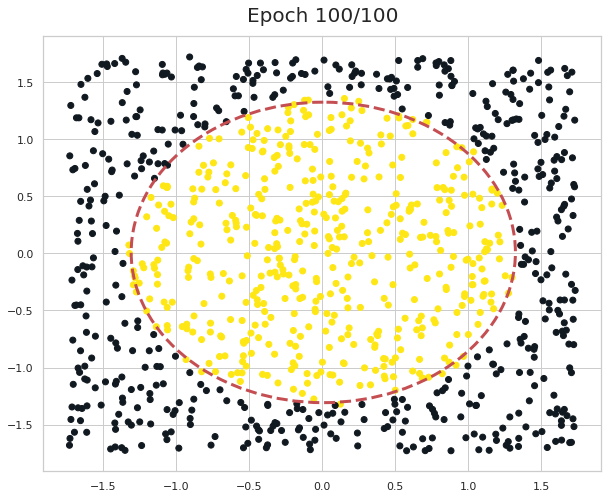

In [6]:
layers =[]
# input layer (2 input units)
linear1 = Linear(2, 25, bias= True, weight_init=xavier_uniform)

# 3 hidden layers (each 25 units)
linear2 = Linear(25, 25, bias= True, weight_init=xavier_uniform)
linear3 = Linear(25, 25, bias= True, weight_init=xavier_uniform)
linear4 = Linear(25, 25, bias= True, weight_init=xavier_uniform)

# output layer (2 output units)
linear5 = Linear(25, 2, bias= True, weight_init=xavier_uniform)


layers.append(linear1)
layers.append(Mish())
layers.append(linear2)
layers.append(Mish())
layers.append(linear3)
layers.append(Mish())
layers.append(linear4)
layers.append(Tanh())
layers.append(linear5)

model = Sequential(layers)

criterion = MSE()
optimizer = SGD(model, lr = 0.1)

losses2 = []
accuracies2 = []
errors2 = []
ret_val2 = ""

for epoch in range(1, epochs+1):
    ret_val2 += "Epoch: " + str(epoch) + "\n"
    for batch_idx in range(0, train_data.size(0), batch_size):
        # axis 0, start from batch_idx until batch_idx+batch_size
        output = model.forward(train_data.narrow(0, batch_idx, batch_size))

        # Calculate loss
        loss = criterion.forward(output, train_label.narrow(0, batch_idx, batch_size))
        losses2.append(loss)
        ret_val2 += "Loss: "+str(loss)+"\n"

        # put to zero weights and bias
        optimizer.zero_grad()

        ##Backpropagation
        # Calculate grad of loss
        loss_grad = criterion.backward()

        # Grad of the model
        model.backward(loss_grad)

        # Update parameters
        optimizer.step()
        
        
     

    test_prediction = model.forward(test_data)
    acc = accuracy(test_prediction, test_label)
    accuracies2.append(acc)
    
    errors2.append(1-acc)
    ret_val2 += "Accuracy: "+ str(acc)+"\n"
    
    pred = torch.argmax(test_prediction, 1)
    fig, ax = plt.subplots(figsize=(10,8))
    ax.scatter(test_data[:,0].numpy(), test_data[:,1].numpy(), c=["#101820FF" if x==0 else "#FEE715FF" for x in np.squeeze(pred.numpy())])
    circle1 = plt.Circle(((0.5-mean.item())/np.power(std,2), (0.5-mean.item())/np.power(std,2)), ((1/np.sqrt(2*np.pi))-mean)/np.power(std,2.07), color='r', fill=False, lw=3, ls="--")
    ax.add_artist(circle1)
    ax.set_title(f"Epoch {epoch}/{epochs}", fontdict={"fontsize":20, "fontweight":1}, pad=15);
    IPyDisplay.clear_output(wait=True)
    IPyDisplay.display(plt.gcf())
    plt.close();
    time.sleep(0.1)
    
if verbose: print(ret_val2)
    

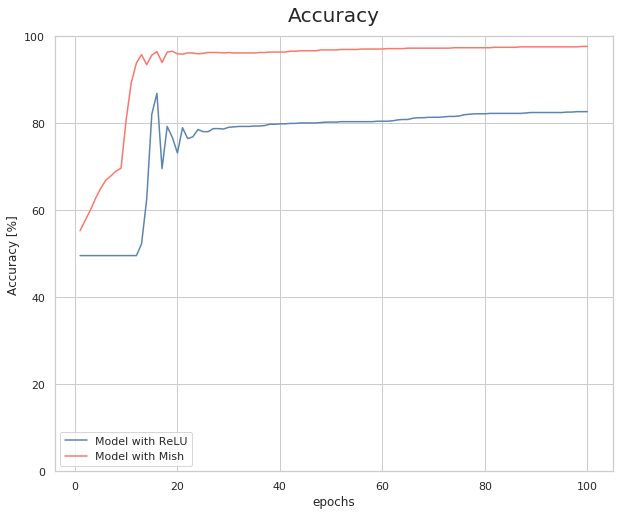

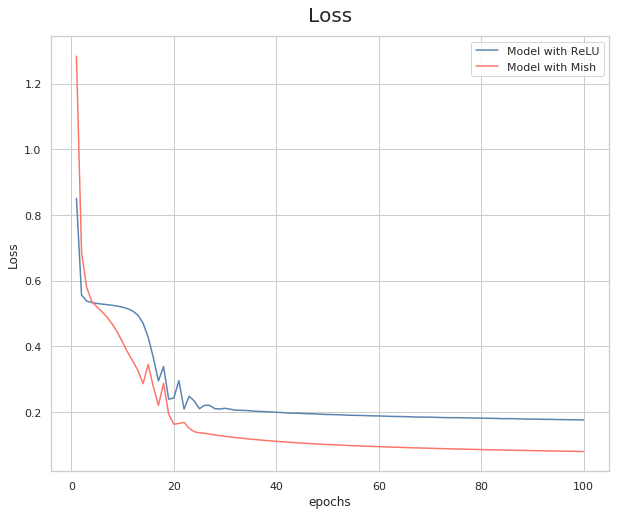

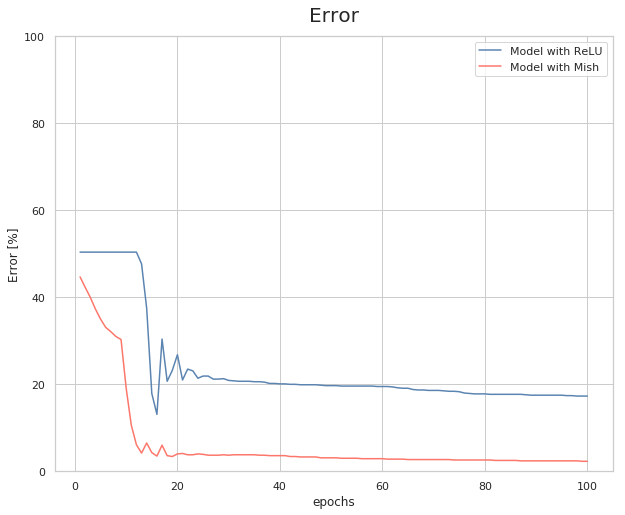

In [7]:
fig, ax = plt.subplots(figsize=(10,8))
sns.lineplot(np.arange(1, len(accuracies)+1), [a.item()*100 for a in accuracies], ax=ax, color="#5B84B1FF", label="Model with ReLU");
sns.lineplot(np.arange(1, len(accuracies2)+1), [a.item()*100 for a in accuracies2], ax=ax, color="#FC766AFF", label="Model with Mish");
#sns.lineplot(x="epoch", y="train_loss", data=df, ax=ax, color="blue", label="train");
ax.set_xlabel("epochs");ax.set_ylabel("Accuracy [%]");ax.set_title("Accuracy", fontdict={"fontsize":20, "fontweight":1}, pad=15);
ax.set_ylim(0,100);
#ax.legend();

fig, ax = plt.subplots(figsize=(10,8))
sns.lineplot(np.arange(1, len(losses[::train_data.size(0)//batch_size])+1), [a.item() for a in losses[::train_data.size(0)//batch_size]], ax=ax, color="#5B84B1FF", label="Model with ReLU");
sns.lineplot(np.arange(1, len(losses2[::train_data.size(0)//batch_size])+1), [a.item() for a in losses2[::train_data.size(0)//batch_size]], ax=ax, color="#FC766AFF", label="Model with Mish");
#sns.lineplot(x="epoch", y="train_loss", data=df, ax=ax, color="blue", label="train");
ax.set_xlabel("epochs");ax.set_ylabel("Loss");ax.set_title("Loss", fontdict={"fontsize":20, "fontweight":1}, pad=15);
#ax.legend();

fig, ax = plt.subplots(figsize=(10,8))
sns.lineplot(np.arange(1, len(errors)+1), [a.item()*100 for a in errors], ax=ax, color="#5B84B1FF", label="Model with ReLU");
sns.lineplot(np.arange(1, len(errors2)+1), [a.item()*100 for a in errors2], ax=ax, color="#FC766AFF", label="Model with Mish");
#sns.lineplot(x="epoch", y="train_loss", data=df, ax=ax, color="blue", label="train");
ax.set_xlabel("epochs");ax.set_ylabel("Error [%]");ax.set_title("Error", fontdict={"fontsize":20, "fontweight":1}, pad=15);
ax.set_ylim(0,100);
#ax.legend();